In [48]:
import pandas as pd
import pydicom
import numpy as np
import os
# from os.path import join, getsize
import random
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from PIL import Image
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization # Main layers
# from keras.layers import Dropout


## Functions

#### Dataframe functions

In [51]:
# function: data display
def df_info(df):
    '''function to display the basic essential information of a loaded dataframe'''
    
    print('Shape : ', df.shape)
    print('\nDescribe : ', df.describe().T)
    print('\nInfo : ', df.info())
    print('\nNull values\n', df.isnull().sum())
    print('\nDuplicate values : ', df.duplicated().sum())

# function: heatmap of df
def corr_heatmap(df, name_of_df):
    ''' function to display the correlation heatmap of a dataframe'''
    
    print('\ndf: ', name_of_df)
    fig, ax = plt.subplots(figsize=(5,4)) 
    cmap = sns.cm.rocket_r
    sns.heatmap(df.corr(), annot=True, linewidths=1, ax=ax, cmap=cmap)

#### function for dicom images -> jpeg

In [100]:
def dicom_jpeg(img_dict, save_path):
    for i in img_dict:
        for j in img_dict[i]:
            # try:
            #load image and convert to pixel array
            image = pydicom.dcmread(f'../data/train/{i}/{j}').pixel_array
            # Rescale image as per jpeg format (jpeg format range upto 255 ... pydicom >4000)
            image = ((image - image.min()) / (image.max() - image.min())) * 255
            # Converting image to grayscale
            image = Image.fromarray(image.astype(np.uint8)).convert('L')
            # Saving the image in jpeg format
            image.save(f"{save_path}/{i}_{j}.jpg")

#### Selecting images for each patient and making a dictionary

In [115]:
def image_per_patient(path):
    image_list = []
    patient_ids = []
    patient_image_list = dict()

    i=0
    for root, dirs, files in os.walk(path):
        patient_ids.extend(dirs)

        if len(files)!=0:
            image_list.append(files)
            patient_image_list[patient_ids[i]] = files
            i+=1
        # if 'CVS' in dirs:
        #     dirs.remove('CVS')  # don't visit CVS directories (contain metadata)

    print('length of dictionary: ', len(patient_image_list))
    # patient_image_list
    # print(patient_ids)
    
    return (patient_image_list, patient_ids, image_list)

#### Dictionary of selected images

In [122]:
# Dictionary of 24 images (slices of each patient)
def dict_24_imgs(week0_list):
    week0_dict_24 = dict()

    for i in week0_list:
        random.seed(42)
        week0_dict_24[i] = random.sample(patient_image_list[i], k=24)

    return week0_dict_24

#### Image feature extraction function

##### ResNet Model

In [59]:
def resnet_featureExtr_model(num_features):
    resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

    # Add a global average pooling layer
    x = resnet_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer with 256 units
    x = Dense(num_features, activation='relu')(x)

    # Define the new model with ResNet50 and the fully connected layer
    resnet_model = Model(inputs=resnet_model.input, outputs=x)
    
    return resnet_model

##### AutoEncoder Model

In [65]:
def autoenc_dimRed(n_initial_features, n_final_features):
    # Define the autoencoder layers
    input_layer = Input(shape=(n_initial_features,))
    encode1 = Dense(64, activation='relu')(input_layer)
    encode2 = Dense(32, activation='relu')(encode1)
    encode3 = Dense(n_final_features, activation='relu')(encode2)

    decode1 = Dense(32, activation='relu')(encode3)
    decode2 = Dense(64, activation='relu')(decode1)
    decode3 = Dense(n_initial_features, activation='sigmoid')(decode2)

    # Define the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decode3)
    encoder_model = Model(inputs=input_layer, outputs=encode3)

    # Compile the autoencoder model with a suitable loss function and optimizer
    autoencoder.compile(optimizer='adam', loss='mse')

    return [autoencoder, encoder_model]

##### Feature Dimension Reduction function

In [79]:
def dimension_reduction(y_pred, patient_list, encoder_model):
    # Encode a single input data point into a compressed representation of shape (1, 8)
    # Also we will be seperating the data of all 18 patients
    image_count = 0
    patient_count = 0
    dict_features = dict()

    dict_features[week0_list[patient_count]] = np.zeros((1,1))

    no_images_per_patient = 24

    iter=0
    for i in y_pred:
        if image_count == no_images_per_patient:
            image_count = 0
            patient_count += 1
            dict_features[patient_list[patient_count]] = np.zeros((1,1))

            input_data = i
            compressed_data = encoder_model.predict(input_data)
            dict_features[week0_list[patient_count]] = np.concatenate((dict_features[week0_list[patient_count]], compressed_data), axis=1)

            image_count += 1
        else:
            input_data = i
            compressed_data = encoder_model.predict(input_data)
            dict_features[week0_list[patient_count]] = np.concatenate((dict_features[week0_list[patient_count]], compressed_data), axis=1)

            image_count += 1
            iter+= 1
        print('Patient: ', patient_count, '... Image: ', image_count, 'Iteration: ...', iter)
        # print(compressed_data.shape)  # Output: (1, 8)
        
    return dict_features

#### Append features to dataframe function

In [84]:
def append_features_to_df(dict_features, df):
    for patient in dict_features:
        feature_count = 0
        for i in dict_features[patient][0]:
            temp_dict = dict()
            temp_dict[patient] = i
            df.loc[df.index[df.Patient == patient][0] ,f'feature {feature_count}'] = i

            feature_count += 1

    # Since we created a zeros array initially of size (1,1), we will remove the junk value (0) column
    df.drop('feature 0', axis=1, inplace=True)

#### Performance metrics function

In [145]:
def perf_mets(y_true, y_pred, msg):
    '''function to find the performance metrics for given predicted and true outputs'''
    print(msg)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print('mean squared error= ', mse, '%\nmean absolute error = ', mae, '\nr sqaured error = ', r2)
    

## Main

In [42]:
df_train = pd.read_csv('../data/train.csv')
df_train

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
...,...,...,...,...,...,...,...
1544,ID00426637202313170790466,13,2712,66.594637,73,Male,Never smoked
1545,ID00426637202313170790466,19,2978,73.126412,73,Male,Never smoked
1546,ID00426637202313170790466,31,2908,71.407524,73,Male,Never smoked
1547,ID00426637202313170790466,43,2975,73.052745,73,Male,Never smoked


In [44]:
df_info(df_train)

Shape :  (1549, 7)

Describe :            count         mean         std         min        25%          50%  \
Weeks    1549.0    31.861846   23.247550   -5.000000    12.0000    28.000000   
FVC      1549.0  2690.479019  832.770959  827.000000  2109.0000  2641.000000   
Percent  1549.0    77.672654   19.823261   28.877577    62.8327    75.676937   
Age      1549.0    67.188509    7.057395   49.000000    63.0000    68.000000   

                 75%          max  
Weeks      47.000000   133.000000  
FVC      3171.000000  6399.000000  
Percent    88.621065   153.145378  
Age        72.000000    88.000000  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age         


df:  training dataset


C:\Users\hdang\AppData\Local\Temp\ipykernel_17436\1914230648.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, linewidths=1, ax=ax, cmap=cmap)


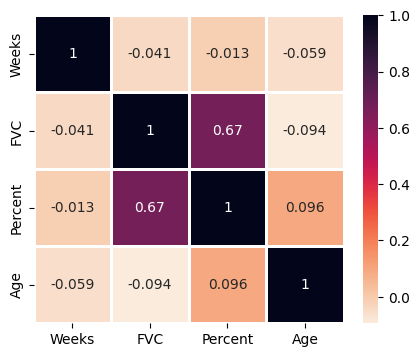

In [52]:
corr_heatmap(df_train, 'training dataset')

#### Making a list and dataframe of patients with week 0 information

In [94]:
df_week0 = df[df.Weeks == 0].reset_index()

week0_list = df[df.Weeks == 0]['Patient'].to_list()
week0_list

['ID00010637202177584971671',
 'ID00014637202177757139317',
 'ID00025637202179541264076',
 'ID00078637202199415319443',
 'ID00094637202205333947361',
 'ID00129637202219868188000',
 'ID00197637202246865691526',
 'ID00210637202257228694086',
 'ID00219637202258203123958',
 'ID00224637202259281193413',
 'ID00283637202278714365037',
 'ID00312637202282607344793',
 'ID00339637202287377736231',
 'ID00344637202287684217717',
 'ID00388637202301028491611',
 'ID00393637202302431697467',
 'ID00405637202308359492977',
 'ID00426637202313170790466']

In [4]:
df_week0

,index,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,18,ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker
1,45,ID00014637202177757139317,0,3807,90.076661,56,Male,Ex-smoker
2,89,ID00025637202179541264076,0,2903,73.777574,65,Male,Ex-smoker
3,279,ID00078637202199415319443,0,1860,68.289459,55,Female,Ex-smoker
4,332,ID00094637202205333947361,0,4916,117.293377,64,Male,Ex-smoker
5,498,ID00129637202219868188000,0,2253,59.622102,71,Male,Never smoked
6,741,ID00197637202246865691526,0,2776,73.790537,65,Male,Currently smokes
7,777,ID00210637202257228694086,0,2846,80.541091,76,Male,Currently smokes
8,822,ID00219637202258203123958,0,6399,153.012912,71,Male,Ex-smoker
9,849,ID00224637202259281193413,0,2992,64.008215,72,Male,Never smoked


In [126]:
# Reading the names of files for each patient
path = '../data/train/'
img_per_patient_data = image_per_patient(path, )

patient_image_list = img_per_patient_data[0]
patient_ids = img_per_patient_data[1]
image_list = img_per_patient_data[2]

length of dictionary:  176


#### Number of slices for each patient


In [57]:
for i in week0_list:
    print(i,':', len(patient_image_list[i]))

ID00010637202177584971671 : 106
ID00014637202177757139317 : 31
ID00025637202179541264076 : 24
ID00078637202199415319443 : 1018
ID00094637202205333947361 : 24
ID00129637202219868188000 : 27
ID00197637202246865691526 : 102
ID00210637202257228694086 : 303
ID00219637202258203123958 : 375
ID00224637202259281193413 : 54
ID00283637202278714365037 : 306
ID00312637202282607344793 : 409
ID00339637202287377736231 : 56
ID00344637202287684217717 : 201
ID00388637202301028491611 : 429
ID00393637202302431697467 : 478
ID00405637202308359492977 : 30
ID00426637202313170790466 : 408


#### Since the minimum number of images are 24, we'll take 24 from each 

### Running the next 2 cells will change the 24 images taken per patient

In [127]:
week0_dict_24 = dict_24_imgs(week0_list)

In [128]:
dicom_jpeg(week0_dict_24, '../data/processed_images/jpg_week0_24')

C:\Users\hdang\AppData\Local\Temp\ipykernel_17436\215229224.py:8: RuntimeWarning: overflow encountered in scalar subtract
  image = ((image - image.min()) / (image.max() - image.min())) * 255


### ResNet50 Feature Extraction

#### Feature Extraction using ResNet50

In [60]:
resnet_model = resnet_featureExtr_model(256)

In [11]:
df_features = pd.DataFrame()

x_train = []
y_pred = []

for i in week0_dict_24:
    list_features = []
    slice_count = 1
    for j in week0_dict_24[i]:
        feature_list = []
        
        image1 = load_img(f'../data/processed_images/jpg_week0_24/{i}_{j}.jpg', target_size=(256,256))
        image1 = img_to_array(image1)
        image1 = preprocess_input(image1)
        
        x_train.append(image1)
        
for i in x_train:
    y_pred.append(resnet_model.predict(np.array([i])))

1/1 [==============================] - 0s 223ms/step


In [12]:
len(y_pred)

432

In [140]:
# 24 features for 18 patients = 432
# merging all data
features_combined = np.concatenate(y_pred, axis=0)

features_combined.shape

(456, 256)

### AutoEncoder Dimension Reduction

In [66]:
autoencoder = autoenc_dimRed(256, 8)[0]
encoder_model = autoenc_dimRed(256,8)[1]

x_train = features_combined
# Train the autoencoder model on the training data
autoencoder.fit(x_train, x_train, epochs=10)

Epoch 1/10
14/14 [==============================] - 1s 3ms/step - loss: 0.4941
Epoch 2/10
14/14 [==============================] - 0s 3ms/step - loss: 0.4512
Epoch 3/10
14/14 [==============================] - 0s 4ms/step - loss: 0.3117
Epoch 4/10
14/14 [==============================] - 0s 3ms/step - loss: 0.2782
Epoch 5/10
14/14 [==============================] - 0s 3ms/step - loss: 0.2738
Epoch 6/10
14/14 [==============================] - 0s 3ms/step - loss: 0.2718
Epoch 7/10
14/14 [==============================] - 0s 3ms/step - loss: 0.2708
Epoch 8/10
14/14 [==============================] - 0s 3ms/step - loss: 0.2705
Epoch 9/10
14/14 [==============================] - 0s 3ms/step - loss: 0.2702
Epoch 10/10
14/14 [==============================] - 0s 3ms/step - loss: 0.2700


In [80]:
dict_features_train = dimension_reduction(y_pred, week0_list, encoder_model)

1/1 [==============================] - 0s 34ms/step
Patient:  0 ... Image:  1 Iteration: ... 1
1/1 [==============================] - 0s 36ms/step
Patient:  0 ... Image:  2 Iteration: ... 2
1/1 [==============================] - 0s 25ms/step
Patient:  0 ... Image:  3 Iteration: ... 3
1/1 [==============================] - 0s 30ms/step
Patient:  0 ... Image:  4 Iteration: ... 4
1/1 [==============================] - 0s 27ms/step
Patient:  0 ... Image:  5 Iteration: ... 5
1/1 [==============================] - 0s 28ms/step
Patient:  0 ... Image:  6 Iteration: ... 6
1/1 [==============================] - 0s 30ms/step
Patient:  0 ... Image:  7 Iteration: ... 7
1/1 [==============================] - 0s 28ms/step
Patient:  0 ... Image:  8 Iteration: ... 8
1/1 [==============================] - 0s 26ms/step
Patient:  0 ... Image:  9 Iteration: ... 9
1/1 [==============================] - 0s 27ms/step
Patient:  0 ... Image:  10 Iteration: ... 10
1/1 [==============================] - 0s 32ms/s

In [81]:
for i in dict_features_train:
    print(dict_features[i].shape)

(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)
(1, 193)


### Appending features in dataframe

In [95]:
append_features_to_df(dict_features_train, df_week0)

C:\Users\hdang\AppData\Local\Temp\ipykernel_17436\2879371906.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df.index[df.Patient == patient][0] ,f'feature {feature_count}'] = i
C:\Users\hdang\AppData\Local\Temp\ipykernel_17436\2879371906.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df.index[df.Patient == patient][0] ,f'feature {feature_count}'] = i
C:\Users\hdang\AppData\Local\Temp\ipykernel_17436\2879371906.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [96]:
df_week0

,index,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,feature 1,feature 2,...,feature 183,feature 184,feature 185,feature 186,feature 187,feature 188,feature 189,feature 190,feature 191,feature 192
0,18,ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,1.217566,0.000000,0.000000,0.000000,0.000000,0.0
1,45,ID00014637202177757139317,0,3807,90.076661,56,Male,Ex-smoker,0.0,0.684680,...,0.077647,0.0,0.0,0.082376,1.003289,0.000000,0.000000,0.000000,0.127652,0.0
2,89,ID00025637202179541264076,0,2903,73.777574,65,Male,Ex-smoker,0.0,0.000000,...,0.125206,0.0,0.0,0.000000,0.661835,0.000000,0.361760,0.000000,0.000000,0.0
3,279,ID00078637202199415319443,0,1860,68.289459,55,Female,Ex-smoker,0.0,0.001547,...,0.180282,0.0,0.0,0.000000,1.025388,0.000000,0.225211,0.000000,0.201760,0.0
4,332,ID00094637202205333947361,0,4916,117.293377,64,Male,Ex-smoker,0.0,0.487772,...,0.274466,0.0,0.0,0.572152,0.574195,0.173252,0.000000,0.000000,0.000000,0.0
5,498,ID00129637202219868188000,0,2253,59.622102,71,Male,Never smoked,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.626183,0.000000,0.163340,0.000000,0.000000,0.0
6,741,ID00197637202246865691526,0,2776,73.790537,65,Male,Currently smokes,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.499089,0.000000,0.000000,0.000000,0.716212,0.0
7,777,ID00210637202257228694086,0,2846,80.541091,76,Male,Currently smokes,0.0,0.000000,...,0.107873,0.0,0.0,0.577507,0.901553,0.000000,0.000000,0.000000,0.203548,0.0
8,822,ID00219637202258203123958,0,6399,153.012912,71,Male,Ex-smoker,0.0,0.169093,...,0.366928,0.0,0.0,0.203182,1.159088,0.000000,0.000000,0.028309,0.412153,0.0
9,849,ID00224637202259281193413,0,2992,64.008215,72,Male,Never smoked,0.0,0.000000,...,0.000000,0.0,0.0,0.997674,1.036752,0.000000,0.000000,0.622907,0.313743,0.0


In [97]:
df_week0.to_csv('../data/df_week0_with_features.csv', index=False)

### Regression on the tabular data

In [98]:
le1 = LabelEncoder()
for i in ['SmokingStatus', 'Sex', 'Patient']:
    df_week0[i] = le1.fit_transform(df_week0[i])

In [22]:
x_train = df_week0.drop(['FVC'], axis=1)
# df_week0_alt = df_week0_alt.reset_index()
y_train = df_week0[['FVC']]

# y_train = df_week0[['FVC', 'Percent']]
# y_train['FVC, Percent']

y_train

,FVC
0,3523
1,3807
2,2903
3,1860
4,4916
5,2253
6,2776
7,2846
8,6399
9,2992


In [23]:
xgb_reg = XGBRegressor()

# train the model on the training set
xgb_reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [25]:
y_pred_xgb = xgb_reg.predict(x_train)

In [146]:
perf_mets(y_train, y_pred_xgb, 'Train data metrics:')

Train data metrics:
mean squared error=  2.723601129319933e-07 %
mean absolute error =  0.0003323025173611111 
r sqaured error =  0.9999999999997956
